# **CONTATOS**

Lucas Pascotti Valem (lucaspascottivalem@gmail.com)

Daniel Pedronette (pedronette@gmail.com)

Obrigado por ter participado do curso! =)

**Instalação do Pytorch Geometric**

In [ ]:
# Primeiro, instalar o PyTorch
!pip install torch torch
!pip install torch torchvision

# Verificar a versão do CUDA para instalar a versão correspondente do PyTorch Geometric
import torch
CUDA_VERSION = torch.version.cuda.replace('.', '')
print("Versão do CUDA:", CUDA_VERSION)

# Instalar o PyTorch Geometric
PYG_VERSION = '2.1.0'  # Escolha a versão de PyTorch Geometric que deseja instalar
TORCH_VERSION = torch.__version__.split('+')[0]

# Comandos para instalar o PyTorch Geometric e suas dependências
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-geometric=={PYG_VERSION}

Versão do CUDA: 121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 48.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 23.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.6/991.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.5/467.5 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Reason for being yanked: Missing ninja templates
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0-py3-none-any.whl size=687143 sha256=3e3b68d975b858ac7e5673753b3ec34c6b06e8dcdc5f2437f5a708536f4ec478
  Stored in directory: /root/.cache/pip/wheels/cb/3f/

**Importar Pacotes**

Importamos as bibliotecas necessárias para manipulação de dados, construção do modelo e avaliação.

In [ ]:
import torch
from sklearn.metrics import roc_auc_score
import torch_geometric.transforms as T
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, to_networkx
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from torch_geometric.datasets import Planetoid

**Seleção de Device**

Escolhemos se o modelo roda na GPU ou CPU.

In [ ]:
# Device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

**Carregar o Dataset**

Carregamos o dataset e dividimos as arestas em conjuntos de treinamento, validação e teste.

In [ ]:
# Load and preprocess the dataset
dataset = KarateClub()
#dataset = Planetoid(root=".", name='Cora')
data = dataset[0]
data = T.NormalizeFeatures()(data)
data = data.to(device)

# Manual seed
#torch.manual_seed(42)

# Apply the RandomLinkSplit transform to create train, validation, and test splits
transform = T.RandomLinkSplit(num_val=0.1, num_test=0.2, is_undirected=True,
                              add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

**Definir o Modelo GCN**

Definimos um modelo GCN simples com duas camadas convolucionais. A função encode gera embeddings dos nós, e a função decode calcula o produto interno entre os embeddings dos nós para prever a existência de arestas.

In [ ]:
# Define the GCN model
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        # Dot product between node embeddings for link prediction
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Predict all potential links
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

**Inicializar o Modelo e o Otimizador**

Configuramos o dispositivo (CPU ou GPU), instanciamos o modelo e definimos o otimizador.

In [ ]:
# Instantiate the model with adjusted hidden dimensions for the small dataset
model = Net(dataset.num_features, 16, 8).to(device)
#model = SGC(dataset.num_features, 8).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

**Definir a Função de Treinamento**

Criamos uma função para treinar o modelo. Ela gera amostras negativas, calcula as predições, calcula a perda e atualiza os parâmetros do modelo.

In [ ]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # Negative sampling
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

**Definir a Função de Teste**

Criamos uma função para avaliar o modelo usando a métrica de Área sob a Curva ROC (AUC).

In [ ]:
# Testing function
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    auc = roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
    return auc

**Treinar e Avaliar o Modelo**

Treinamos o modelo por um número especificado de épocas e, periodicamente, imprimimos o desempenho na validação.

Após o treinamento, avaliamos o modelo no conjunto de teste e imprimimos as métricas de desempenho.

In [ ]:
# Training loop
best_val_auc = final_test_auc = 0
for epoch in range(1, 51):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, '
          f'Test AUC: {test_auc:.4f}')
print(f'Final Test AUC: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6927, Val AUC: 0.6122, Test AUC: 0.7911
Epoch: 002, Loss: 0.6881, Val AUC: 0.6327, Test AUC: 0.7600
Epoch: 003, Loss: 0.6827, Val AUC: 0.6327, Test AUC: 0.7511
Epoch: 004, Loss: 0.6788, Val AUC: 0.6327, Test AUC: 0.7467
Epoch: 005, Loss: 0.6778, Val AUC: 0.6122, Test AUC: 0.7467
Epoch: 006, Loss: 0.6663, Val AUC: 0.6531, Test AUC: 0.7511
Epoch: 007, Loss: 0.6611, Val AUC: 0.6939, Test AUC: 0.7600
Epoch: 008, Loss: 0.6571, Val AUC: 0.7143, Test AUC: 0.7733
Epoch: 009, Loss: 0.6372, Val AUC: 0.7143, Test AUC: 0.7778
Epoch: 010, Loss: 0.6233, Val AUC: 0.7347, Test AUC: 0.7911
Epoch: 011, Loss: 0.6412, Val AUC: 0.7755, Test AUC: 0.7822
Epoch: 012, Loss: 0.6059, Val AUC: 0.8367, Test AUC: 0.7733
Epoch: 013, Loss: 0.6001, Val AUC: 0.8776, Test AUC: 0.7156
Epoch: 014, Loss: 0.5887, Val AUC: 0.8776, Test AUC: 0.6978
Epoch: 015, Loss: 0.5600, Val AUC: 0.8571, Test AUC: 0.7067
Epoch: 016, Loss: 0.5348, Val AUC: 0.8571, Test AUC: 0.7111
Epoch: 017, Loss: 0.5219, Val AUC: 0.877

**Visualizar o Grafo**

Plotamos o grafo com as arestas preditas.

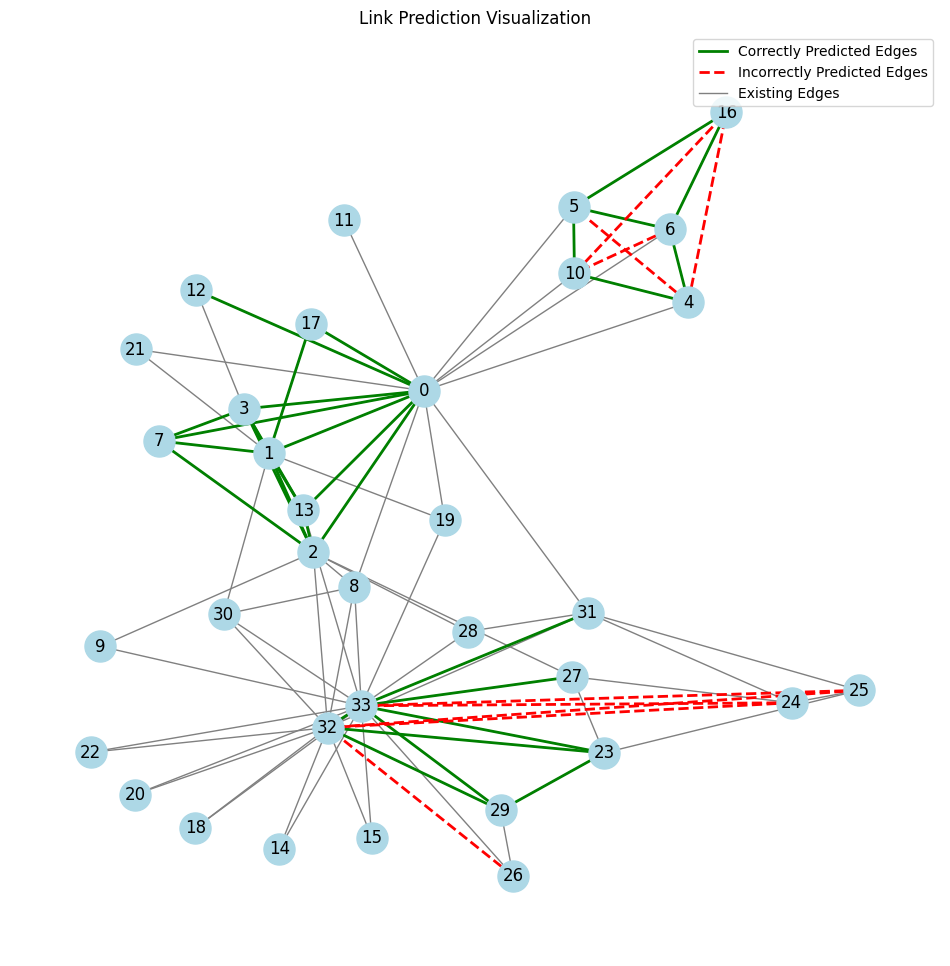

In [ ]:
# Final encoding and edge prediction
with torch.no_grad():
    model.eval()
    z = model.encode(data.x, data.edge_index)

    # Generate all possible node pairs (undirected, excluding self-loops)
    row, col = torch.triu_indices(data.num_nodes, data.num_nodes, offset=1)
    edge_candidates = torch.stack([row, col], dim=0).to(device)
    edge_probs = model.decode(z, edge_candidates).sigmoid()

    # Sort the edges based on probabilities
    sorted_probs, sorted_indices = torch.sort(edge_probs, descending=True)
    sorted_edge_candidates = edge_candidates[:, sorted_indices]

    # Take top-k predicted edges
    k = 40  # Adjust k as needed
    top_edge_indices = sorted_edge_candidates[:, :k]
    predicted_edges = [(u.item(), v.item()) for u, v in top_edge_indices.t()]

    # Actual edges in the data
    edge_set = set([(min(u.item(), v.item()), max(u.item(), v.item())) for u, v in data.edge_index.t()])

    # Check if predicted edges are correct
    is_correct = []
    for u, v in predicted_edges:
        u, v = min(u, v), max(u, v)
        is_correct.append((u, v) in edge_set)

# Visualization
# Convert to networkx graph
G = to_networkx(data, to_undirected=True)

# Positions for all nodes
pos = nx.spring_layout(G, seed=42)  # Fixed seed for consistent layout

# Draw nodes and labels
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos)

# Draw existing edges
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)

# Separate correct and incorrect predicted edges
correct_edges = [edge for edge, correct in zip(predicted_edges, is_correct) if correct]
incorrect_edges = [edge for edge, correct in zip(predicted_edges, is_correct) if not correct]

# Draw predicted edges
nx.draw_networkx_edges(G, pos, edgelist=correct_edges, edge_color='green', width=2, style='solid')
nx.draw_networkx_edges(G, pos, edgelist=incorrect_edges, edge_color='red', width=2, style='dashed')

# Create legend
legend_elements = [Line2D([0], [0], color='green', lw=2, label='Correctly Predicted Edges'),
                   Line2D([0], [0], color='red', lw=2, linestyle='dashed', label='Incorrectly Predicted Edges'),
                   Line2D([0], [0], color='gray', lw=1, label='Existing Edges')]

plt.legend(handles=legend_elements, loc='best')

plt.title('Link Prediction Visualization')
plt.axis('off')
plt.show()